# ResNet50 CBIS-DDSM

In [1]:
# import libraries
import numpy as np 
import os
from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.gridspec as gridspec
from scipy.ndimage import zoom

# import data proprocessing functions from dataprep.py
from dataprep import load_dataframes, move_masked_images_from_cropped_directories, convert_images_to_png, image_augmentation
from dataprep import apply_clahe_on_images, image_resizing, split_data, create_train_val_test_dirs, print_class_distribution

# import keras functionalities
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers.legacy import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.applications.resnet50 import preprocess_input as pi_50
from keras.preprocessing import image
from keras import backend as K
from keras import models

# Data Preprocessing

In [2]:
# please see dataprep.py what each function does
df_calc, df_mass = load_dataframes(
    get_unique_images=True,
    drop_without_callback=False,
    total=True
)

move_masked_images_from_cropped_directories(
    df=df_mass,
    threshold=1
)

convert_images_to_png(
    df=df_mass
)

image_augmentation(
    df=df_mass,
    rotation_angles=[90, 180, 270]
)

apply_clahe_on_images(
    df=df_mass,
    clip_limit=2
)

image_resizing(
    df=df_mass, 
    resizing_dims=(224, 224, 3)
)

df_train_malignant, df_train_benign, df_val_malignant, df_val_benign, df_test_malignant, df_test_benign = split_data(df=df_mass)

create_train_val_test_dirs(
    df_train_malignant=df_train_malignant,
    df_train_benign=df_train_benign,
    df_val_malignant=df_val_malignant,
    df_val_benign=df_val_benign,
    df_test_malignant=df_test_malignant,
    df_test_benign=df_test_benign
)

print_class_distribution(
    source_dir='../Data/CBIS-DDSM dataset/base_dir/train',
    set='Train'
)

print_class_distribution(
    source_dir='../Data/CBIS-DDSM dataset/base_dir/validation',
    set='Validation'
)

print_class_distribution(
    source_dir='../Data/CBIS-DDSM dataset/base_dir/test',
    set='Test'
)

######################################
#                                    #
#      Preproccesing started         #
#                                    #
######################################
------------------ Removing masked images ------------------
Successfully completed
---------------- Converting images to PNG ----------------
Successfully completed
------------------ Applying augmentation ------------------
Successfully completed
------------------ Applying CLAHE ------------------
Successfully completed
------------------ Resizing images ------------------
Successfully completed
------------------ Creating train, test, and validation sets ------------------
Successfully completed
------------------ Moving images to directory structure for training ------------------
Successfully completed
######################################
#                                    #
#      Preproccesing ended           #
#                                    #
#################################

# Modeling

In [ ]:
# define hyperparameter ranges to cross-validate over
dropout_list = [0.6, 0.5, 0.4]
kr_list = [1e-1, 5e-2, 1e-3, 5e-4]
lr_list = [1e-5, 1e-5, 1e-4, 1e-3]

# define some other parameters
epochs = 30
batch_size = 32
image_shape = (224,224,3)

# define where to find the data, in what directories
base_dir = f'../Data/CBIS-DDSM dataset/base_dir'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# get the train, val, test sample size
train_sample_count = len(os.listdir(train_dir+'/benign')) + len(os.listdir(train_dir+'/malignant'))
val_sample_count = len(os.listdir(validation_dir+'/benign')) + len(os.listdir(validation_dir+'/malignant'))
test_sample_count = len(os.listdir(test_dir+'/benign')) + len(os.listdir(test_dir+'/malignant'))

# define a path where to save to models parameters
safe_model_path = '../Models_unfrozen'
os.makedirs(safe_model_path, exist_ok=True)

train_datagen = ImageDataGenerator(preprocessing_function=pi_50)
validation_datagen = ImageDataGenerator(preprocessing_function=pi_50)

# this is an object containing the train images, loaded from the directory, preprocessed using the dataprep,
# and defines that we are working with categorical responses (binary)
train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=image_shape[:2],
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True
            )

# this is an object containing the validation images, loaded from the directory, preprocessed using the dataprep,
# and defines that we are working with categorical responses (binary)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  
)

# this is an object containing the test images, loaded from the directory, preprocessed using the dataprep,
# and defines that we are working with categorical responses (binary)
test_generator = validation_datagen.flow_from_directory(
                test_dir,
                target_size=image_shape[:2],
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=False
            )

# start the cross validation
for learning_rate in lr_list:
    for dropout in dropout_list:
        for kernel_reg in kr_list:

            # intialize pre trained resnet50 model without last fully connected layer for 10000 classes
            base_model = ResNet50(include_top=False,
                                input_shape=image_shape,
                                weights='imagenet')

            # freeze first 4 blocks, unfreeze last 5th block
            x = base_model.output
            base_model.trainable = False
            for layer in base_model.layers:
                if "conv5" in layer.name:
                    layer.trainable = True

            # add layers on top of resnet50 to comply with our classifcation task
            x = Flatten()(x)
            x = Dropout(dropout)(x)
            predictions = Dense(2, activation='softmax', kernel_regularizer=l2(kernel_reg))(x)

            # configure, compile the model using adam optimization
            model = Model(inputs=base_model.input, outputs=predictions)

            model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['acc'])

            # use early stopping during training with patience of 5
            early_stopping = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)

            history = model.fit(
                train_generator,
                steps_per_epoch=train_sample_count // batch_size,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=val_sample_count // batch_size,
                callbacks=[early_stopping]
            )
            
            # evaluate fitted model on test set
            test_loss, test_accuracy = model.evaluate(test_generator)

            # save model
            model.save(f"{safe_model_path}/unfrozen_{round(test_accuracy,3)}_{round(test_loss, 3)}_{dropout}_{kernel_reg}_{learning_rate}.keras")

In [161]:
# load best model from cross-validation and calculate accuracy, sensitivity, and specificity
model_path = '../Models_unfrozen/unfrozen_0.791_0.756_0.6_0.05_1e-05.keras'
model = load_model(model_path)

predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

tn, fp, fn, tp = confusion_matrix(true_classes, predictions).ravel()
accuracy = accuracy_score(true_classes, predictions)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

22/22 [==============================] - 19s 445ms/step
Accuracy: 0.7909356725146199
Sensitivity: 0.7310126582278481
Specificity: 0.842391304347826


# Visualizing intermediate activation maps

#### The following cell does the exact same thing as I did for the MNIST classification task with the CNN, except now for multiple convolutional layers. For commented code, please refer to the mnist.ipynb notebook under the section "Visualizing intermediate activation maps"

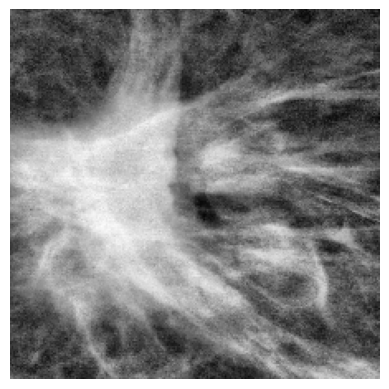

1/1 [==============================] - 5s 5s/step


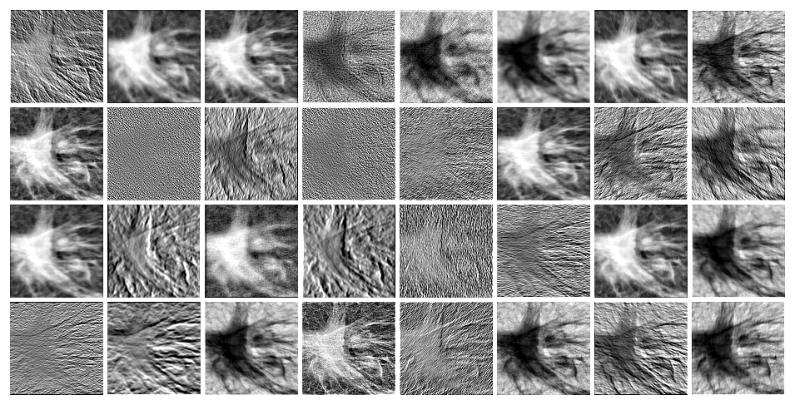

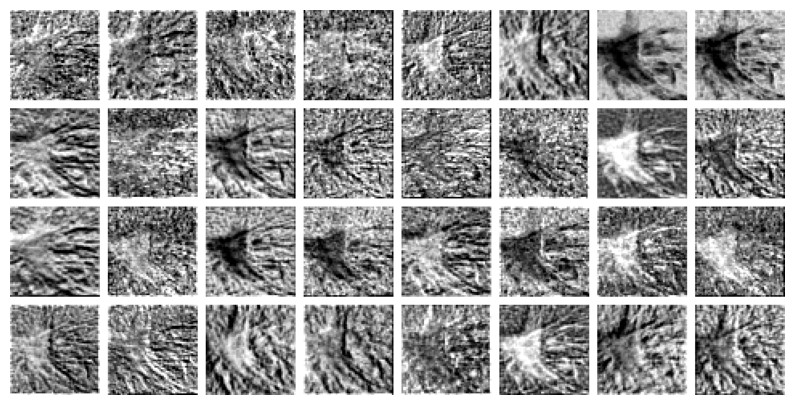

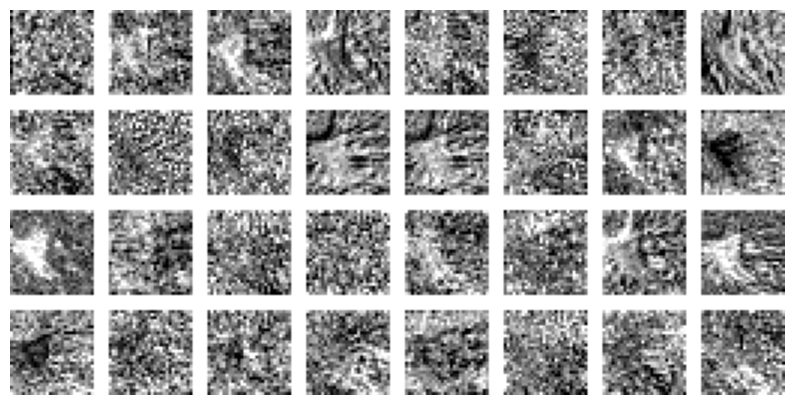

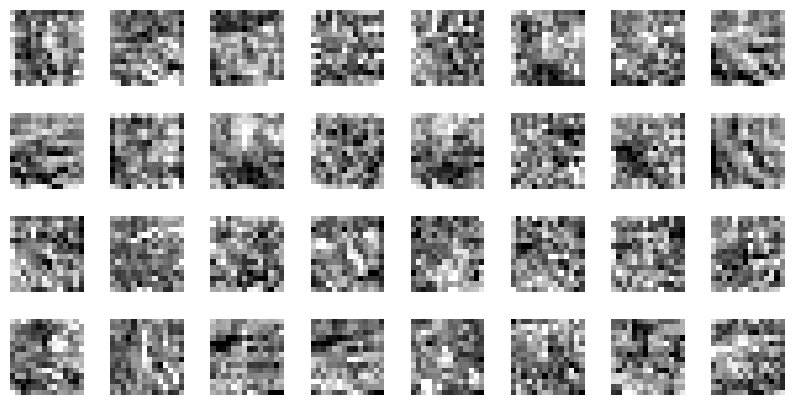

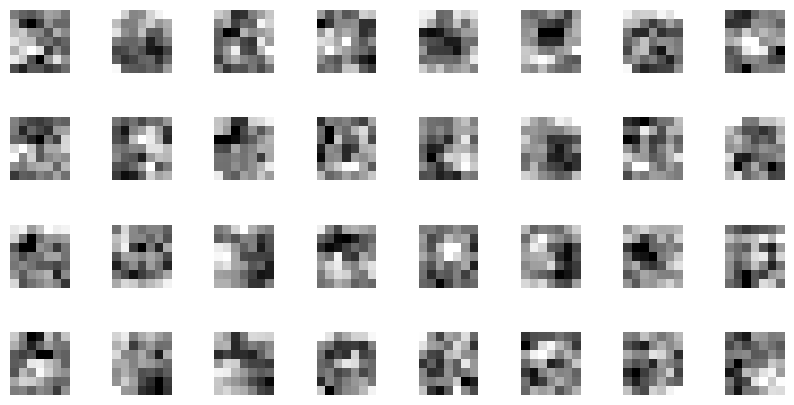

In [3]:
model_path = '../Models_unfrozen/unfrozen_0.791_0.756_0.6_0.05_1e-05.keras'

base_dir = f'../Data/CBIS-DDSM dataset/base_dir'
test_dir = os.path.join(base_dir, 'test')
test_b_dir = os.path.join(test_dir, 'benign')
test_m_dir = os.path.join(test_dir, 'malignant')

def show_activations(dir):

    images_list = os.listdir(dir)
    image_path = os.path.join(dir, '2-022.png')
    img = image.load_img(image_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    plt.imshow(img_tensor[0])
    plt.axis('off')
    plt.savefig('../Figures/activations/malignant_example.png', dpi=400, bbox_inches='tight')
    plt.show()
    img_tensor *= 255.

    model = load_model(model_path)
    resnet_model = model.layers[0]

    layer_names = ['conv1_conv', 'conv2_block2_1_conv', 'conv3_block1_1_conv', 'conv4_block1_1_conv', 'conv5_block1_1_conv']
    activation_model = models.Model(inputs=resnet_model.input, outputs=[resnet_model.get_layer(name).output for name in layer_names])
    activations = activation_model.predict(img_tensor)

    images_per_row = 8
    space_between = 5
    max_maps = 32 
    block = 1

    for layer_name, layer_activation in zip(layer_names, activations):
        size = layer_activation.shape[1] 

        n_cols = max_maps // images_per_row
        display_grid = np.ones(((size + space_between) * n_cols - space_between,
                                 (size + space_between) * images_per_row - space_between)) * 255

        for col in range(n_cols):
            for row in range(images_per_row):
                chnl_ind = col * images_per_row + row
                if chnl_ind >= max_maps:
                    break
                channel_image = layer_activation[0, :, :, col * images_per_row + row]

                channel_image -= channel_image.mean()
                channel_image /= channel_image.std() + 1e-5  
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')

                col_start = (col * (size + space_between))
                col_end = col_start + size
                row_start = (row * (size + space_between))
                row_end = row_start + size
                
                display_grid[col_start: col_end, row_start: row_end] = channel_image

        plt.figure(figsize=(10,5))
        # plt.title(layer_name)
        plt.axis('off')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')
        # plt.savefig(f'../Figures/activations/activations_block{block}.png', dpi=400, bbox_inches='tight')
        plt.show()
        block+=1

show_activations(dir=test_m_dir)


# Visualizing kernels

#### The following cell does the exact same thing as I did for the MNIST classification task with the CNN, except now for multiple convolutional layers. For commented code, please refer to the mnist.ipynb notebook under the section "Visualizing kernels"

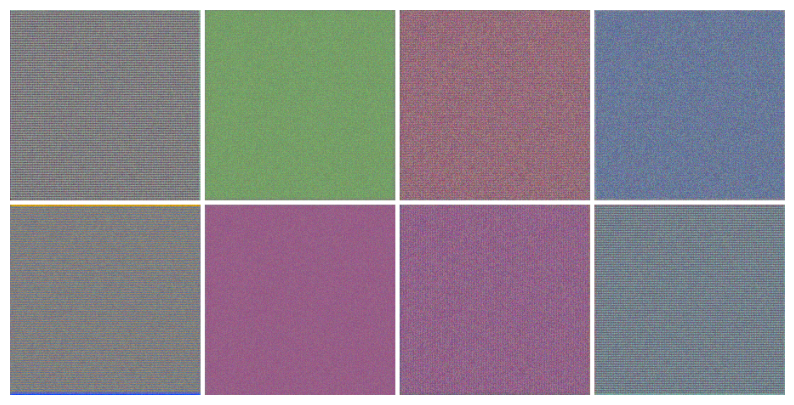

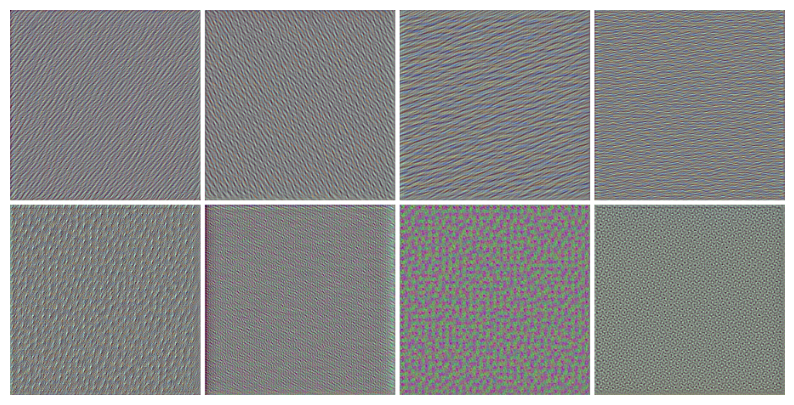

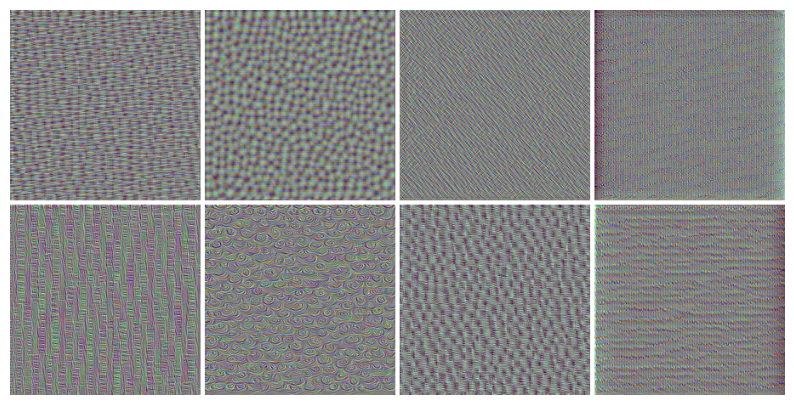

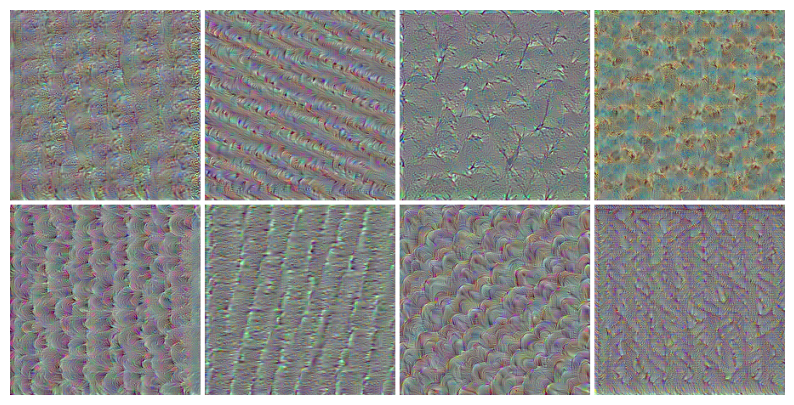

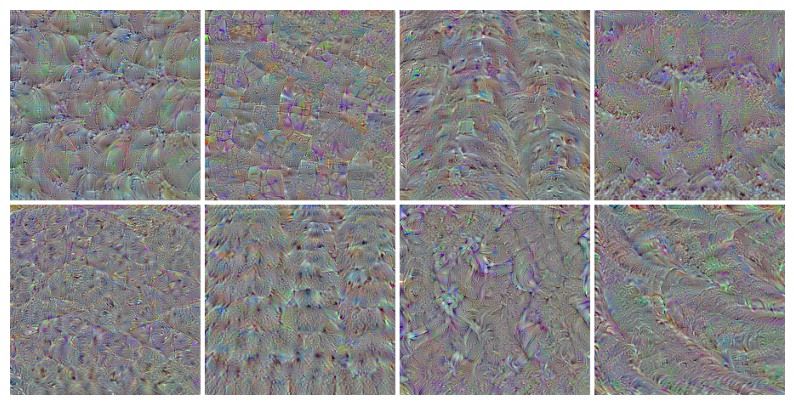

In [7]:
model_path = '../Models_unfrozen/unfrozen_0.791_0.756_0.6_0.05_1e-05.keras'

def deprocess_image(image):

    image -= image.mean()
    image /= (image.std() + 1e-5)
    image *= 0.1
    image += 0.5
    image = np.clip(image, 0, 1)
    image *= 255
    image = np.clip(image, 0, 255).astype('uint8')

    return image

def generate_pattern(model, input_img_data, layer_name, filter_index, lr=1, iter=200):
    intermediate_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    for i in range(iter):
        with tf.GradientTape() as tape:
            tape.watch(input_img_data)
            activations = intermediate_model(input_img_data)
            loss = tf.reduce_mean(activations[:, :, :, filter_index])

        grads = tape.gradient(loss, input_img_data)
        grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
        input_img_data += grads * lr

    img = input_img_data[0].numpy()
    return deprocess_image(img)

model = load_model(model_path)
resnet_model = model.layers[0]
# layer_name = 'conv1_conv'
# layer_name = 'conv2_block2_1_conv'
# layer_name = 'conv3_block1_1_conv'
# layer_name = 'conv4_block1_1_conv'
# layer_name = 'conv5_block3_3_conv'
layer_names = ['conv1_conv', 'conv2_block2_1_conv', 'conv3_block1_1_conv', 'conv4_block1_1_conv', 'conv5_block1_1_conv']
images_per_row = 4
space_between = 5
max_kernels = 8
block = 1

input_img_data = tf.convert_to_tensor(np.random.random((1, 224, 224, 3)) * 20 + 128)

size = 224 
n_cols = max_kernels // images_per_row
display_grid = np.ones(((size + space_between) * n_cols - space_between,
                        (size + space_between) * images_per_row - space_between, 3)) * 255

for layer_name in layer_names:
    for filter_index in range(max_kernels):
        if block == 1:
            filter_img = generate_pattern(resnet_model, input_img_data, layer_name, filter_index, lr=0.1)
        else:
            filter_img = generate_pattern(resnet_model, input_img_data, layer_name, filter_index, lr=1)

        col = filter_index // images_per_row
        row = filter_index % images_per_row
        col_start = (col * (size + space_between))
        col_end = col_start + size
        row_start = (row * (size + space_between))
        row_end = row_start + size

        display_grid[col_start: col_end, row_start: row_end, :] = filter_img


    plt.figure(figsize=(10,5))
    plt.axis('off')
    plt.grid(False)
    plt.imshow(display_grid.astype('uint8'), aspect='auto')
    # plt.savefig(f'../Figures/kernels/kernels_block{block}.png', dpi=400, bbox_inches='tight')
    plt.show()
    block += 1

# Visualizing heatmaps of class activation

#### The following cell does the exact same thing as I did for the MNIST classification task with the CNN, except now for multiple convolutional layers. For commented code, please refer to the mnist.ipynb notebook under the section "Visualizing heatmaps of class activation". The only difference is that we now look at both missclassified and correctly classified images. This part IS commented in the cell below.

In [2]:
base_dir = f'../Data/CBIS-DDSM dataset/base_dir'
test_dir = os.path.join(base_dir, 'test')
test_b_dir = os.path.join(test_dir, 'benign')
test_m_dir = os.path.join(test_dir, 'malignant')

batch_size = 32
image_shape = (224,224,3)

validation_datagen = ImageDataGenerator(preprocessing_function=pi_50)

test_generator = validation_datagen.flow_from_directory(
                test_dir,
                target_size=image_shape[:2],
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=False
            )

model_path = '../Models_unfrozen/unfrozen_0.782_0.768_0.6_0.05_1e-05.keras'
model = load_model(model_path)

# get predictions of the model on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
filenames = test_generator.filenames

# check which ones are correctly classified and which one are incorrectly classified
misclassified_indices = np.where(predicted_classes != true_classes)[0]
correctly_classified_indices = np.where(predicted_classes == true_classes)[0]

# put all missclassified images in a list
misclassified_images = [filenames[i] for i in misclassified_indices]
misclassified_images = [i for i in misclassified_images if len(i.split("_")) <= 1]
benign_mis = []
malignant_mis = []
for i in range(len(misclassified_images)):
    if misclassified_images[i][:6] == 'benign':
        benign_mis.append(misclassified_images[i])
    if misclassified_images[i][:9] == 'malignant':
        malignant_mis.append(misclassified_images[i])

# put all correctly classified images in a list
correctly_classified_images = [filenames[i] for i in correctly_classified_indices]
correctly_classified_images = [i for i in correctly_classified_images if len(i.split("_")) <= 1]
benign_cor = []
malignant_cor = []
for i in range(len(correctly_classified_images)):
    if correctly_classified_images[i][:6] == 'benign':
        benign_cor.append(correctly_classified_images[i])
    if correctly_classified_images[i][:9] == 'malignant':
        malignant_cor.append(correctly_classified_images[i])

benign_mis_cam = ['benign/2-183.png', 'benign/1-115.png']
malignant_mis_cam = ['malignant/1-044.png', 'malignant/1-153.png']
benign_cor_cam = ['benign/1-013.png', 'benign/1-041.png']
malignant_cor_cam = ['malignant/1-124.png', 'malignant/2-022.png']

def get_image(dir, image_name, process_image):

    image_path = os.path.join(dir, image_name)
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    if process_image:
        return pi_50(img)
    else:
        return img

last_conv_layer_name = 'conv5_block3_3_conv'
last_conv_layer_output = model.get_layer(last_conv_layer_name).output

model_with_conv_output = Model(inputs=model.input, 
                               outputs=[model.output, last_conv_layer_output])

def generate_cam(image_name):

    img_tensor = get_image(dir=test_dir, image_name=image_name, process_image=True)
    with tf.GradientTape() as tape:
        inputs = tf.cast(img_tensor, tf.float32)
        tape.watch(inputs)

        predictions, last_conv_output = model_with_conv_output(inputs)
        predicted_class = tf.argmax(predictions[0])
        predicted_class_output = predictions[:, predicted_class]
    
    grads = tape.gradient(predicted_class_output, last_conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_output = last_conv_output.numpy()[0]
    for i in range(pooled_grads.shape[-1]):
        last_conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    img = get_image(dir=test_dir, image_name=image_name, process_image=False)
    original_img = img[0, :, :, 0]
    original_img /= np.max(original_img)
    heatmap_size = original_img.shape[0]
    heatmap_resized = zoom(heatmap, (heatmap_size / heatmap.shape[0], heatmap_size / heatmap.shape[1]), order=1)
    colored_heatmap = plt.cm.jet(heatmap_resized)[:, :, :3]  # Get only the color channels


    superimposed_img = colored_heatmap * 0.4 + original_img.reshape((224, 224, 1))
    superimposed_img = np.clip(superimposed_img / superimposed_img.max(), 0, 1)

    return original_img, superimposed_img

benign1_org, cam1 = generate_cam(image_name=benign_mis_cam[0])
benign2_org, cam2 = generate_cam(image_name=benign_mis_cam[1])

mal1_org, cam3 = generate_cam(image_name=malignant_mis_cam[0])
mal2_org, cam4 = generate_cam(image_name=malignant_mis_cam[1])

benign3_org, cam5 = generate_cam(image_name=benign_cor_cam[0])
benign4_org, cam6 = generate_cam(image_name=benign_cor_cam[1])

malignant3_org, cam7 = generate_cam(image_name=malignant_cor_cam[0])
malignant4_org, cam8 = generate_cam(image_name=malignant_cor_cam[1])

Found 684 images belonging to 2 classes.


2024-03-11 11:09:51.272687: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-11 11:09:51.272708: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-11 11:09:51.272736: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-11 11:09:51.272802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-11 11:09:51.272824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-03-11 11:09:58.329691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 13s 371ms/step


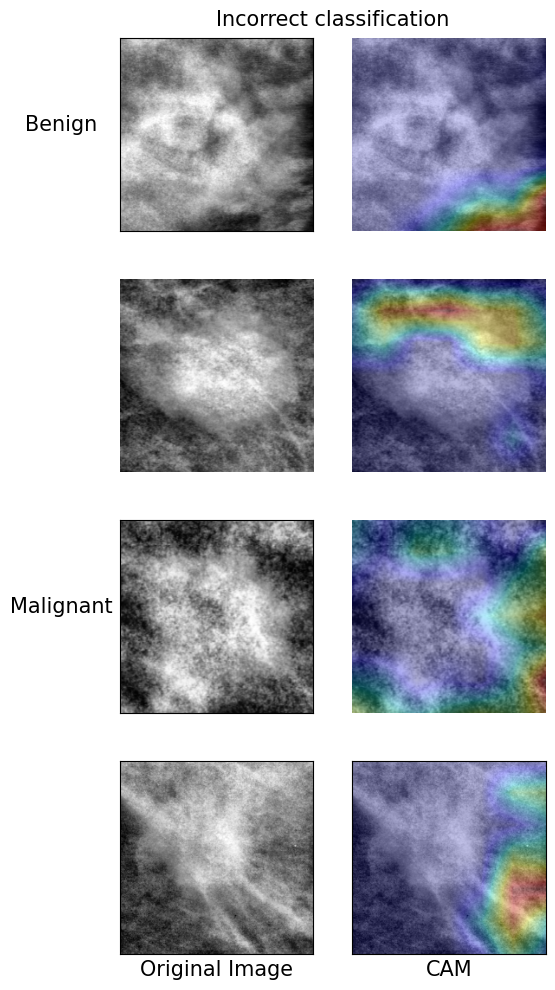

In [24]:
fontsize=15

plt.figure(figsize=(5.5, 12))
plt.title('Incorrect classification', fontsize=fontsize)
plt.axis('off')

plt.subplot(4, 2, 1)
plt.imshow(benign1_org, cmap='gray')
plt.ylabel('Benign', fontsize=fontsize, rotation=0, labelpad=42)
plt.xticks([])
plt.yticks([])

plt.subplot(4, 2, 2)
plt.imshow(cam1)
plt.axis('off')

plt.subplot(4, 2, 3)
plt.imshow(benign2_org, cmap='gray')
plt.axis('off')

plt.subplot(4, 2, 4)
plt.imshow(cam2)
plt.axis('off')

plt.subplot(4, 2, 5)
plt.imshow(mal1_org, cmap='gray')
plt.ylabel('Malignant', fontsize=fontsize, rotation=0, labelpad=42)
plt.xticks([])
plt.yticks([])

plt.subplot(4, 2, 6)
plt.imshow(cam3)
plt.axis('off')

plt.subplot(4, 2, 7)
plt.imshow(mal2_org, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel('Original Image', fontsize=fontsize)

plt.subplot(4, 2, 8)
plt.imshow(cam4)
plt.xticks([])
plt.yticks([])
plt.xlabel('CAM', fontsize=fontsize)

plt.savefig('../Figures/incorrect_class.png', dpi=400, bbox_inches='tight')
plt.show()

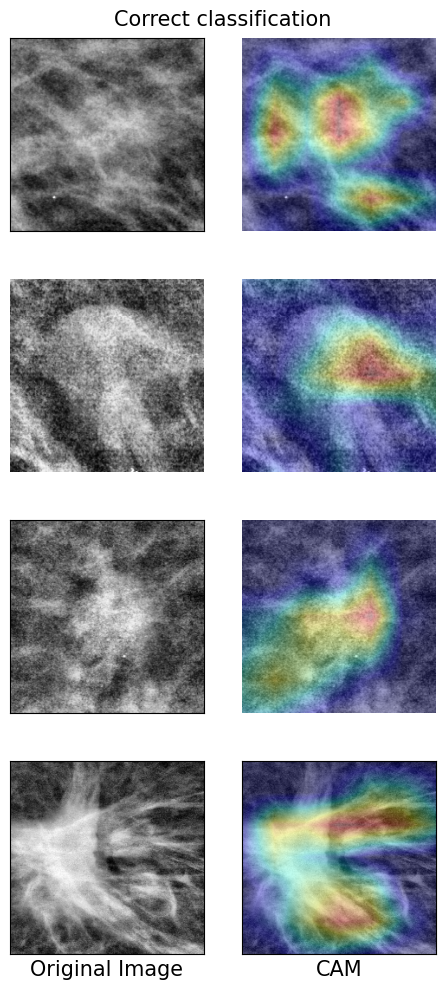

In [25]:
fontsize=15

plt.figure(figsize=(5.5, 12))
plt.title('Correct classification', fontsize=fontsize)
plt.axis('off')

plt.subplot(4, 2, 1)
plt.imshow(benign3_org, cmap='gray')
# plt.ylabel('Benign', fontsize=fontsize, rotation=0, labelpad=42)
plt.xticks([])
plt.yticks([])

plt.subplot(4, 2, 2)
plt.imshow(cam5)
plt.axis('off')

plt.subplot(4, 2, 3)
plt.imshow(benign4_org, cmap='gray')
plt.axis('off')

plt.subplot(4, 2, 4)
plt.imshow(cam6)
plt.axis('off')

plt.subplot(4, 2, 5)
plt.imshow(malignant3_org, cmap='gray')
# plt.ylabel('Malignant', fontsize=fontsize, rotation=0, labelpad=42)
plt.xticks([])
plt.yticks([])

plt.subplot(4, 2, 6)
plt.imshow(cam7)
plt.axis('off')

plt.subplot(4, 2, 7)
plt.imshow(malignant4_org, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel('Original Image', fontsize=fontsize)

plt.subplot(4, 2, 8)
plt.imshow(cam8)
plt.xticks([])
plt.yticks([])
plt.xlabel('CAM', fontsize=fontsize)

plt.savefig('../Figures/correct_class.png', dpi=400, bbox_inches='tight')
plt.show()

In [89]:
model_path = '../Models_unfrozen/unfrozen_0.791_0.756_0.6_0.05_1e-05.keras'
model = load_model(model_path)
resnet = model.layers[0]

for layer_name in resnet.layers:
    print(layer_name.name)

input_10
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3